In [6]:
import torch

class PermutationMatrixGenerator:
    def __init__(self, m):
        self.m = m
    
    def get_permutation_matrices(self, matrices):
        batch_size = matrices.size(0)

        # Compute L2 norms for rows and columns
        row_norms = matrices.norm(p=2, dim=2)  # (batch_size, m)
        col_norms = matrices.norm(p=2, dim=1)  # (batch_size, m)
        
        # Get sorted indices for rows and columns
        row_indices = torch.argsort(row_norms, dim=1, descending=True)  # (batch_size, m)
        col_indices = torch.argsort(col_norms, dim=1, descending=True)  # (batch_size, m)
        
        # Generate permutation matrices
        eye = torch.eye(self.m, device=matrices.device)
        P_r = eye[row_indices]  # (batch_size, m, m)
        P_c = eye[col_indices]  # (batch_size, m, m)
        
#         Permute rows and columns
        permuted_matrices = torch.bmm(P_r, torch.bmm(matrices, P_c.transpose(1, 2)))
        permuted_matrices = P_r@matrices@P_c.transpose(1, 2)
        permuted_matrices = matrices
        # permuted_matrices = permuted_matrices[:,col_indices,:]
        # permuted_matrices = permuted_matrices[:,:,row_indices]
        
        return permuted_matrices

# Example usage
m = 100  # Dimension of the square matrices
batch_size = 10000  # Number of matrices in the batch

# Create a batch of random matrices
batch_matrices = torch.randn(batch_size, m, m)

# Initialize and use the PermutationMatrixBatch class
PMG = PermutationMatrixGenerator(m)
permuted_matrices = PMG.get_permutation_matrices(batch_matrices)

# print("Row permutation matrices:")
# print(row_perm_matrices)

# print("Column permutation matrices:")
# print(col_perm_matrices)

print("Permuted matrices:")
print(permuted_matrices.shape)


Permuted matrices:
torch.Size([10000, 100, 100])


In [17]:
# # for i in range(100):
# permuted_matrices = torch.bmm(row_perm_matrices, torch.bmm(batch_matrices, col_perm_matrices.transpose(1, 2)))
# permuted_matrices = torch.bmm(row_perm_matrices, torch.bmm(batch_matrices, col_perm_matrices.transpose(1, 2)))

In [18]:
permuted_matrices.norm(p=2, dim=2)

tensor([[[[1.2002, 4.2191, 0.8069],
          [1.1861, 4.5224, 1.3562],
          [1.3634, 4.9314, 1.0873]],

         [[1.1861, 4.5224, 1.3562],
          [1.2002, 4.2191, 0.8069],
          [1.3634, 4.9314, 1.0873]],

         [[0.7369, 3.0883, 1.3144],
          [1.6541, 5.8458, 0.9047],
          [1.1946, 4.3430, 1.0613]],

         [[1.6501, 5.9358, 1.1374],
          [0.7505, 2.8190, 1.0074],
          [1.1918, 4.4036, 1.1679]],

         [[1.2002, 4.2191, 0.8069],
          [1.1861, 4.5224, 1.3562],
          [1.3634, 4.9314, 1.0873]],

         [[0.7505, 2.8190, 1.0074],
          [1.6501, 5.9358, 1.1374],
          [1.1918, 4.4036, 1.1679]],

         [[0.7505, 2.8190, 1.0074],
          [1.6501, 5.9358, 1.1374],
          [1.1918, 4.4036, 1.1679]],

         [[1.2002, 4.2191, 0.8069],
          [1.1861, 4.5224, 1.3562],
          [1.3634, 4.9314, 1.0873]],

         [[1.1861, 4.5224, 1.3562],
          [1.2002, 4.2191, 0.8069],
          [1.3634, 4.9314, 1.0873]],

         [

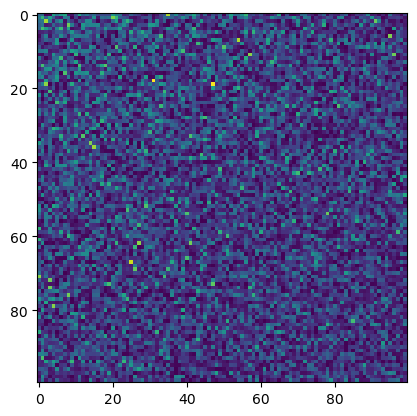

In [60]:
import matplotlib.pyplot as plt
plt.imshow(torch.abs(permuted_matrices[0]))

In [8]:
import torch

class NormSorter:
    def __init__(self):
        pass

    def sort_rows_and_columns(self, matrices):
        """
        Sort the rows and columns of each matrix in the batch by decreasing L2 norm.
        
        Args:
            matrices (torch.Tensor): A batch of n x n matrices of shape (batch_size, n, n)
        
        Returns:
            torch.Tensor: A batch of sorted n x n matrices of shape (batch_size, n, n)
        """
        batch_size, n, _ = matrices.shape
        
        # Compute the L2 norm for rows and columns
        row_norms = torch.norm(matrices, dim=2, p=2)  # shape: (batch_size, n)
        col_norms = torch.norm(matrices, dim=1, p=2)  # shape: (batch_size, n)
        
        # Sort indices by decreasing L2 norm
        row_sorted_indices = torch.argsort(row_norms, dim=1, descending=True)  # shape: (batch_size, n)
        col_sorted_indices = torch.argsort(col_norms, dim=1, descending=True)  # shape: (batch_size, n)
        
        # Create a batch index tensor
        batch_indices = torch.arange(batch_size).unsqueeze(1)  # shape: (batch_size, 1)
        
        # Sort rows using advanced indexing
        sorted_matrices = matrices[batch_indices, row_sorted_indices]  # shape: (batch_size, n, n)
        
        # Transpose the matrices to sort columns
        sorted_matrices = sorted_matrices.transpose(1, 2)  # shape: (batch_size, n, n)
        
        # Sort columns (now rows in the transposed matrices)
        sorted_matrices = sorted_matrices[batch_indices, col_sorted_indices]  # shape: (batch_size, n, n)
        
        # Transpose back to original shape
        sorted_matrices = sorted_matrices.transpose(1, 2)  # shape: (batch_size, n, n)
        
        return sorted_matrices

# Example usage
batch_size, n = 10000, 100
matrices = torch.rand(batch_size, n, n)
sorter = NormSorter()
sorted_matrices = sorter.sort_rows_and_columns(matrices)

print("Original matrices:")
print(matrices)
print("\nSorted matrices:")
print(sorted_matrices)


Original matrices:
tensor([[[1.3947e-01, 8.2762e-01, 8.3919e-01,  ..., 5.7510e-01,
          9.1285e-01, 2.7353e-01],
         [3.9243e-01, 9.1133e-01, 7.9694e-01,  ..., 9.3672e-01,
          3.2191e-01, 2.2304e-01],
         [2.0280e-01, 6.0529e-01, 8.8748e-01,  ..., 1.8050e-01,
          2.0103e-02, 2.5081e-01],
         ...,
         [7.3617e-01, 9.2195e-01, 4.5912e-02,  ..., 7.6402e-01,
          2.4723e-01, 1.2911e-01],
         [5.7276e-01, 1.5653e-01, 9.5189e-01,  ..., 9.7637e-01,
          2.9899e-01, 5.3958e-01],
         [4.3351e-01, 6.1247e-01, 8.0002e-01,  ..., 5.2502e-01,
          2.1107e-01, 5.7848e-01]],

        [[8.7370e-01, 4.6168e-01, 5.1457e-01,  ..., 9.0268e-01,
          4.5524e-01, 2.5124e-01],
         [7.5816e-01, 6.1478e-01, 9.3002e-01,  ..., 8.1334e-01,
          2.3137e-01, 5.2643e-01],
         [6.5757e-01, 1.0396e-01, 1.2298e-01,  ..., 8.6364e-01,
          8.2561e-01, 2.2543e-01],
         ...,
         [1.4488e-01, 2.6594e-01, 3.7562e-02,  ..., 8.9041e-

In [10]:
torch.norm(sorted_matrices, dim=2, p=2)

tensor([[6.3260, 6.2633, 6.2566,  ..., 5.1419, 4.9872, 4.9358],
        [6.3485, 6.2647, 6.2568,  ..., 5.3129, 5.3042, 5.2461],
        [6.3411, 6.1782, 6.1747,  ..., 5.1675, 5.1159, 5.0400],
        ...,
        [6.2983, 6.2314, 6.1613,  ..., 5.2325, 5.2080, 5.1983],
        [6.4135, 6.3374, 6.3179,  ..., 5.2926, 5.1515, 4.9308],
        [6.2637, 6.2266, 6.1974,  ..., 5.3359, 5.2978, 5.0997]])

In [29]:
import torch

class NormSorter:
    def __init__(self):
        pass

    def sort_rows_and_columns(self, matrices):
        """
        Sort the rows and columns of each matrix in the batch by decreasing L2 norm.
        
        Args:
            matrices (torch.Tensor): A batch of n x n matrices of shape (batch_size, n, n)
        
        Returns:
            torch.Tensor: A batch of sorted n x n matrices of shape (batch_size, n, n)
            torch.Tensor: Row sorted indices of shape (batch_size, n)
            torch.Tensor: Column sorted indices of shape (batch_size, n)
        """
        batch_size, n, _ = matrices.shape
        
        # Compute the L2 norm for rows and columns
        row_norms = torch.norm(matrices, dim=2, p=2)  # shape: (batch_size, n)
        col_norms = torch.norm(matrices, dim=1, p=2)  # shape: (batch_size, n)
        
        # Sort indices by decreasing L2 norm
        row_sorted_indices = torch.argsort(row_norms, dim=1, descending=True)  # shape: (batch_size, n)
        col_sorted_indices = torch.argsort(col_norms, dim=1, descending=True)  # shape: (batch_size, n)
        
        # Create a batch index tensor
        batch_indices = torch.arange(batch_size)#.unsqueeze(1)  # shape: (batch_size, 1)
        n_indices = torch.arange(n)

        # Sort rows using advanced indexing
        sorted_matrices = matrices[batch_indices[:,None,None], row_sorted_indices[:,:,None], col_sorted_indices[:,None,:]]  # shape: (batch_size, n, n)


        # # Transpose the matrices to sort columns
        # sorted_matrices = sorted_matrices.transpose(1, 2)  # shape: (batch_size, n, n)
        
        # # Sort columns (now rows in the transposed matrices)
        # sorted_matrices = sorted_matrices[batch_indices[:,None], col_sorted_indices]  # shape: (batch_size, n, n)
        
        # # Transpose back to original shape
        # sorted_matrices = sorted_matrices.transpose(1, 2)  # shape: (batch_size, n, n)
        
        return sorted_matrices, row_sorted_indices, col_sorted_indices

    def unsort(self, sorted_matrices, row_sorted_indices, col_sorted_indices):
        """
        Unsort the matrices back to their original order.
        
        Args:
            sorted_matrices (torch.Tensor): A batch of sorted n x n matrices of shape (batch_size, n, n)
            row_sorted_indices (torch.Tensor): Row sorted indices of shape (batch_size, n)
            col_sorted_indices (torch.Tensor): Column sorted indices of shape (batch_size, n)
        
        Returns:
            torch.Tensor: A batch of unsorted n x n matrices of shape (batch_size, n, n)
        """
        batch_size, n, _ = sorted_matrices.shape
        
        # Create inverse indices for rows and columns
        row_unsorted_indices = torch.argsort(row_sorted_indices, dim=1)  # shape: (batch_size, n)
        col_unsorted_indices = torch.argsort(col_sorted_indices, dim=1)  # shape: (batch_size, n)
        
        # Create a batch index tensor
        batch_indices = torch.arange(batch_size)#.unsqueeze(1)  # shape: (batch_size, 1)
        
        # # Unsort columns using advanced indexing
        # unsorted_matrices = sorted_matrices.transpose(1, 2)[batch_indices, col_unsorted_indices].transpose(1, 2)
        
        # # Unsort rows using advanced indexing
        # unsorted_matrices = unsorted_matrices[batch_indices, row_unsorted_indices]

        unsorted_matrices = sorted_matrices[batch_indices[:,None,None], row_unsorted_indices[:,:,None], col_unsorted_indices[:,None,:]]
        
        return unsorted_matrices

# Example usage
batch_size, n = 1, 2
matrices = torch.rand(batch_size, n, n)
sorter = NormSorter()
sorted_matrices, row_sorted_indices, col_sorted_indices = sorter.sort_rows_and_columns(matrices)

print("Original matrices:")
print(matrices)
print("\nSorted matrices:")
print(sorted_matrices)

# Unsort the matrices
unsorted_matrices = sorter.unsort(sorted_matrices, row_sorted_indices, col_sorted_indices)
print("\nUnsorted matrices (should match the original):")
print(unsorted_matrices)


Original matrices:
tensor([[[0.5094, 0.7227],
         [0.0332, 0.9930]]])

Sorted matrices:
tensor([[[0.9930, 0.0332],
         [0.7227, 0.5094]]])

Unsorted matrices (should match the original):
tensor([[[0.5094, 0.7227],
         [0.0332, 0.9930]]])


In [14]:
torch.norm(sorted_matrices, dim=2, p=2)

tensor([[1.2083, 1.0681, 0.9560, 0.9126]])

In [39]:
import numpy as np

In [42]:
A = np.random.uniform(size=(3,3))
A

array([[0.34832615, 0.45990711, 0.6183064 ],
       [0.20536121, 0.67742789, 0.87293763],
       [0.20903602, 0.6728025 , 0.40806258]])

In [49]:
A_inv = np.linalg.inv(A)
A_inv

array([[ 4.7803436 , -3.51092613,  0.26736714],
       [-1.51730184, -0.1982146 ,  2.72307845],
       [ 0.05288515,  2.12533411, -2.17609603]])

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 5.0/5.0 MB 12.8 MB/s eta 0:00:00
     ---------------------------------------- 4.0/4.0 MB 16.0 MB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 GB 828.3 kB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1


In [43]:
P = np.array([[0,1,0],[1,0,0],[0,0,1]])

In [45]:
P@A

array([[0.20536121, 0.67742789, 0.87293763],
       [0.34832615, 0.45990711, 0.6183064 ],
       [0.20903602, 0.6728025 , 0.40806258]])

In [48]:
PA_inv = np.linalg.inv(P@A)
PA_inv

array([[-3.51092613,  4.7803436 ,  0.26736714],
       [-0.1982146 , -1.51730184,  2.72307845],
       [ 2.12533411,  0.05288515, -2.17609603]])